In [1]:
import ga_lib_3 as ga_lib
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import intake
import pickle
import gzip
import umap
import glob
import os.path
import numpy as np
from collections import defaultdict,namedtuple
%pylab inline

plt.style.use('tableau-colorblind10')
plt.rcParams['font.size'] = '16'
figdir = '/home/glandrum/Papers/MolecularTimeSeries/images/'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


# Filter the assay datasets to only include those with at least 3 log units of activity range

In [2]:
catalog = intake.open_catalog('./datasets/public_data.yaml')
bioactivities = catalog.assays

assays_to_keep = []
for assay in bioactivities:
    ds = bioactivities[assay]
    metadata = ds.metadata
    if metadata['max pchembl_value']-metadata['min pchembl_value'] >= 3.0:
        assays_to_keep.append(assay)
print(f'Kept {len(assays_to_keep)} of {len(bioactivities)} datasets')
    

Kept 103 of 132 datasets


In [3]:
import glob
import os

def score_pareto_solutions(Fs,weights,q=0.9):
    weights = np.array(weights)
    Fs = np.copy(Fs)
    qs = np.quantile(Fs,q,axis=0)
    for i in range(len(qs)):
        if qs[i]==0.0:
            qs[i] = 1.0
    Fs /= qs
    Fs = np.exp(Fs*-1)
    weights = np.array(weights,float)
    # normalize:
    weights /= np.sum(weights)
    
    Fs *= weights
    return np.sum(Fs,axis=1)


from sklearn.model_selection import StratifiedShuffleSplit
def alt_compliance_analysis(assay,strategy='CLUSTERS_SPLIT',popSize=500,nGens=300,
                           isBalanced=True, noGap=True):

    sel_strategy = getattr(ga_lib.SelectionStrategy,strategy)

    catalog = intake.open_catalog('./datasets/public_data.yaml')
    bioactivities = catalog.assays

    if noGap:
        dirname = "nogap_"
        window = 0.0
    else:
        dirname = ""
        window = 0.3
    if not isBalanced:
        dirname += 'alt_results_imbalanced_assay'
    else:
        dirname += 'alt_results_balanced_assay'
    
    
    for scen in range(2):
        fname = f'./{dirname}/{assay}_{strategy}.{popSize}.{nGens}.altscenario_{scen}.pkl.gz'
        if not os.path.exists(fname):
            # short-circuit if we can't find results for one scenario
            return {}

    
    ds = bioactivities[assay]
    print('------------\nLoading data')
    df = ds.read()
    # randomize the order:
    df = df.sample(frac=1,random_state=0xf00d)
    
    
    # Use the binning scheme
    # generate the binned activity values
    pActs = np.array(
        [-1 * math.log10(x*1e-9) if x > 0 else 0 for x in df.standard_value])
    df['pActivity'] = pActs
    if not isBalanced:
        upper, lower = ga_lib.get_imbalanced_bins(pActs)
    else:
        upper, lower = ga_lib.get_imbalanced_bins(pActs,tgt_frac=0.4,active_inactive_offset=window)
    print(f'  bins are: {lower:.2f} {upper:.2f}')
    df = df[(pActs >= upper) | (pActs <= lower)]
    binned = [1 if x >= upper else 0 for x in df.pActivity]
    df['active'] = ['active' if x == 1 else 'inactive' for x in binned]
    print(f'  post-binning data size {len(df)}')
    
    dvals = np.array([ga_lib.calc_descrs(m) for m in df.mol])
    dtgts = ga_lib.get_descr_targets()
    fps = ga_lib.get_fps(df.mol)
    dmat = np.zeros((len(fps),len(fps)),float)
    for i,fp in enumerate(fps):
        if i==len(fps)-1:
            break
        ds = np.array(DataStructs.BulkTanimotoSimilarity(fp,fps[i+1:],returnDistance=1))
        dmat[i,i+1:] = ds
        dmat[i+1:,i] = ds
    print(len(df))
       
    max_pts = len(binned)
    keep = max_pts
    n_max = int(0.2*keep)
    print(f'working with {keep} points and picking {n_max}')

    
    binned = np.array(binned)

    res = {}

    for scen in range(2):
        fname = f'./{dirname}/{assay}_{strategy}.{popSize}.{nGens}.altscenario_{scen}.pkl.gz'
        if not os.path.exists(fname):
            break
        with gzip.open(fname,'rb') as inf:
            train_inds,test_inds = pickle.load(inf)
            Fs,Gs,Xs = pickle.load(inf)

        tgts = [x.target_value for x in ga_lib.descrs]
        descr_names = [x.descriptor for x in ga_lib.descrs]
        nDescrs = len(descr_names)
        descr_names.append('delta_frac_active')
        tgts.append(ga_lib.delta_test_active_frac_vals[scen])

        vals = []
        for x in Xs:
            train = np.median(dvals[~x], axis=0)
            test = np.median(dvals[x], axis=0)
            descr_deltas = test - train
            lres = list(descr_deltas)
            
            train_acts = binned[~x]
            train_frac = np.sum(train_acts, axis=0) / len(train_acts)
            test_acts = binned[x]
            test_frac = np.sum(test_acts, axis=0) / len(test_acts)
            dTestFracActive = test_frac - np.sum(binned, axis=0)/len(binned)
            lres.append(dTestFracActive)
            
            allIdx = np.arange(0, len(x), dtype=int)
            testIdx = allIdx[x]
            trainIdx = allIdx[~x]
            _, g_vals, f_vals, _ = ga_lib.modified_spatial_stats_dmat(
                dmat, testIdx, trainIdx, includeTestInBootstrap=False)
            sum_F = np.sum(f_vals)
            sum_G = np.sum(g_vals)
            lres.append(sum_F)
            lres.append(sum_G)           
            vals.append(lres)
        res[scen] = (tgts,np.array(vals))
    # short circuit if we couldn't read in all the results
    if len(res)<2:
        return res
    
    # random split results
    sss = StratifiedShuffleSplit(n_splits = 10, test_size=0.2, random_state=0xf00d)
    fvs = []
    gvs = []
    for train,test in sss.split(fps,binned):
        _, g_vals, f_vals, _ = ga_lib.modified_spatial_stats_dmat(
            dmat, test, train, includeTestInBootstrap=False)
        sum_F = np.sum(f_vals)
        sum_G = np.sum(g_vals)
        fvs.append(sum_F)
        gvs.append(sum_G)
    res[-1] = (fvs,gvs)

    
    return res


In [4]:
restuple = namedtuple('restuple',['rocs','scores','kappas','BAs'])

tmp_assays = glob.glob('./nogap_ml_results_balanced_assay/*.pkl.gz')
nogap_random_results_bal = {}
for fn in tmp_assays:
    assay = os.path.basename(fn).split('_')[0]
    if assay not in assays_to_keep:
        continue
    with gzip.open(fn,'rb') as inf:
        tpl = restuple(*pickle.load(inf))
    nogap_random_results_bal[assay] = tpl
assays = list(nogap_random_results_bal.keys())

tmp_assays = glob.glob('./mfp0_nogap_ml_results_balanced_assay/*.pkl.gz')
mfp0_nogap_random_results_bal = {}
for fn in tmp_assays:
    assay = os.path.basename(fn).split('_')[0]
    if assay not in assays_to_keep:
        continue
    with gzip.open(fn,'rb') as inf:
        tpl = restuple(*pickle.load(inf))
    mfp0_nogap_random_results_bal[assay] = tpl


In [5]:
len(assays),len(mfp0_nogap_random_results_bal)

(103, 103)

# Look at final distributions of actives

In [6]:
catalog = intake.open_catalog('./datasets/public_data.yaml')
bioactivities = catalog.assays

ds_stats=defaultdict(list)
for assay in assays:
    ds = bioactivities[assay]

    print('------------\nLoading data')
    df = ds.read()
    print(f'  original data size {len(df)}')
    # randomize the order of the molecules:
    # this is easy with a data frame, but you could also random.shuffle() a list if the mols are in a list.
    df = df.sample(frac=1, random_state=0xf00d)

    # generate the binned activity values
    pActs = np.array(
        [-1 * math.log10(x*1e-9) if x > 0 else 0 for x in df.standard_value])
    df['pActivity'] = pActs
    upper, lower = ga_lib.get_imbalanced_bins(pActs,tgt_frac=0.4,active_inactive_offset=0.0)
    print(f'  bins are: {lower:.2f} {upper:.2f}')
    df = df[(pActs >= upper) | (pActs <= lower)]
    binned = [1 if x >= upper else 0 for x in df.pActivity]
    df['active'] = ['active' if x == 1 else 'inactive' for x in binned]
    print(f'  post-binning data size {len(df)}')
    ds_stats['final_size'].append(len(df))
    ds_stats['frac_active'].append(sum(binned)/len(df))
    ds_stats['lower'].append(lower)
    ds_stats['upper'].append(upper)
    
    
    

------------
Loading data
  original data size 404
  bins are: 7.30 7.30
  post-binning data size 404
------------
Loading data
  original data size 339
  bins are: 5.20 5.20
  post-binning data size 339
------------
Loading data
  original data size 425
  bins are: 5.10 5.10
  post-binning data size 425
------------
Loading data
  original data size 448
  bins are: 7.40 7.40
  post-binning data size 448
------------
Loading data
  original data size 317
  bins are: 7.10 7.10
  post-binning data size 317
------------
Loading data
  original data size 329
  bins are: 8.30 8.30
  post-binning data size 329
------------
Loading data
  original data size 653
  bins are: 5.40 5.40
  post-binning data size 653
------------
Loading data
  original data size 419
  bins are: 8.40 8.40
  post-binning data size 419
------------
Loading data
  original data size 571
  bins are: 5.30 5.30
  post-binning data size 571
------------
Loading data
  original data size 566
  bins are: 5.20 5.20
  post-bi

  bins are: 7.60 7.60
  post-binning data size 794
------------
Loading data
  original data size 440
  bins are: 7.40 7.40
  post-binning data size 440
------------
Loading data
  original data size 408
  bins are: 7.20 7.20
  post-binning data size 408
------------
Loading data
  original data size 564
  bins are: 7.50 7.50
  post-binning data size 564
------------
Loading data
  original data size 607
  bins are: 7.50 7.50
  post-binning data size 607
------------
Loading data
  original data size 620
  bins are: 8.70 8.70
  post-binning data size 620
------------
Loading data
  original data size 468
  bins are: 6.90 6.90
  post-binning data size 468
------------
Loading data
  original data size 301
  bins are: 7.90 7.90
  post-binning data size 301
------------
Loading data
  original data size 367
  bins are: 8.00 8.00
  post-binning data size 367
------------
Loading data
  original data size 305
  bins are: 8.80 8.80
  post-binning data size 305
------------
Loading data
  ori

Check what we actually got

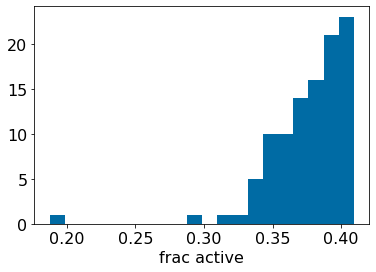

In [7]:
hist(ds_stats['frac_active'],bins=20)
xlabel('frac active');

# Random model performance

## Baseline calculation

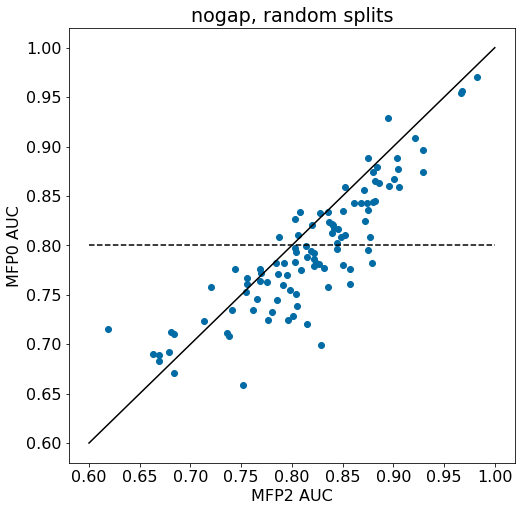

In [10]:
figsize(8,8)
scatter([np.median(nogap_random_results_bal[x].rocs) for x in assays],
        [np.median(mfp0_nogap_random_results_bal[x].rocs) for x in assays]);
plot((.6, 1),(.6, 1),'k')
plot((0.6,1),(0.8,0.8),'k--')
xlabel('MFP2 AUC')
ylabel('MFP0 AUC');
title('nogap, random splits');

plt.savefig(f'{figdir}/chembl_assays_mfp0_vs_mfp2.pdf',bbox_inches='tight')


In [6]:
meds = np.array([np.median(mfp0_nogap_random_results_bal[x].rocs) for x in  mfp0_nogap_random_results_bal])
assays_80 = [x for x,m in zip(mfp0_nogap_random_results_bal,meds) if m<=0.80]
indices_80 = [i for i,m in enumerate(meds) if m<=0.80]
for ka in assays_80:
    print(ka,np.median(mfp0_nogap_random_results_bal[ka].rocs),np.median(nogap_random_results_bal[ka].rocs))

CHEMBL3705282 0.7950689289501591 0.8753976670201484
CHEMBL3705542 0.7350654664484452 0.7618657937806874
CHEMBL1267248 0.714975845410628 0.6183574879227054
CHEMBL1267246 0.6703778677462888 0.6838731443994602
CHEMBL3705464 0.7608695652173914 0.7561315496098104
CHEMBL1267251 0.7107407407407407 0.6839506172839507
CHEMBL1267250 0.6828512396694215 0.6694214876033058
CHEMBL1267249 0.6917207792207792 0.6788961038961039
CHEMBL1267247 0.6889740566037736 0.6686320754716981
CHEMBL1267245 0.6902252906976745 0.6627906976744187
CHEMBL3705362 0.775 0.8094148936170213
CHEMBL3705655 0.7764756944444444 0.7434895833333334
CHEMBL3705790 0.7460488505747126 0.765625
CHEMBL3705647 0.7819237147595357 0.8234867330016583
CHEMBL3705813 0.7240802675585284 0.7964046822742475
CHEMBL3705791 0.7717391304347826 0.7692934782608696
CHEMBL3705971 0.7641402714932126 0.7683823529411764
CHEMBL3705924 0.6994575936883629 0.8288954635108481
CHEMBL3705899 0.7775427463423233 0.8315705975674247
CHEMBL3705960 0.728587962962963 0.80

In [7]:
len(assays_80)

59

Data for table with info about selected assays

In [14]:

catalog = intake.open_catalog('./datasets/public_data.yaml')
bioactivities = catalog.assays

sizes = []
for assay in assays_80:
    ds = bioactivities[assay]
    sizes.append(len(ds.read()))
    print(rf'{assay} & {ds.metadata["activity_type"]} & {sizes[-1]} \\')
len(sizes)

CHEMBL3705282 & IC50 & 317 \\
CHEMBL3705542 & Ki & 363 \\
CHEMBL1267248 & IC50 & 339 \\
CHEMBL1267246 & IC50 & 571 \\
CHEMBL3705464 & IC50 & 306 \\
CHEMBL1267251 & IC50 & 653 \\
CHEMBL1267250 & IC50 & 495 \\
CHEMBL1267249 & IC50 & 566 \\
CHEMBL1267247 & IC50 & 425 \\
CHEMBL1267245 & IC50 & 533 \\
CHEMBL3705362 & IC50 & 720 \\
CHEMBL3705655 & IC50 & 430 \\
CHEMBL3705790 & IC50 & 383 \\
CHEMBL3705647 & IC50 & 511 \\
CHEMBL3705813 & IC50 & 357 \\
CHEMBL3705791 & IC50 & 313 \\
CHEMBL3705971 & Ki & 427 \\
CHEMBL3705924 & IC50 & 325 \\
CHEMBL3705899 & IC50 & 766 \\
CHEMBL3705960 & IC50 & 480 \\
CHEMBL3706037 & IC50 & 641 \\
CHEMBL3706310 & IC50 & 367 \\
CHEMBL3706316 & IC50 & 365 \\
CHEMBL3706089 & IC50 & 574 \\
CHEMBL3707951 & IC50 & 318 \\
CHEMBL3706373 & Ki & 733 \\
CHEMBL3889139 & Ki & 301 \\
CHEMBL3887759 & IC50 & 333 \\
CHEMBL3888268 & Ki & 347 \\
CHEMBL3887796 & IC50 & 458 \\
CHEMBL3721139 & EC50 & 310 \\
CHEMBL3887679 & IC50 & 376 \\
CHEMBL3734552 & EC50 & 395 \\
CHEMBL3887061 & Ki &

59

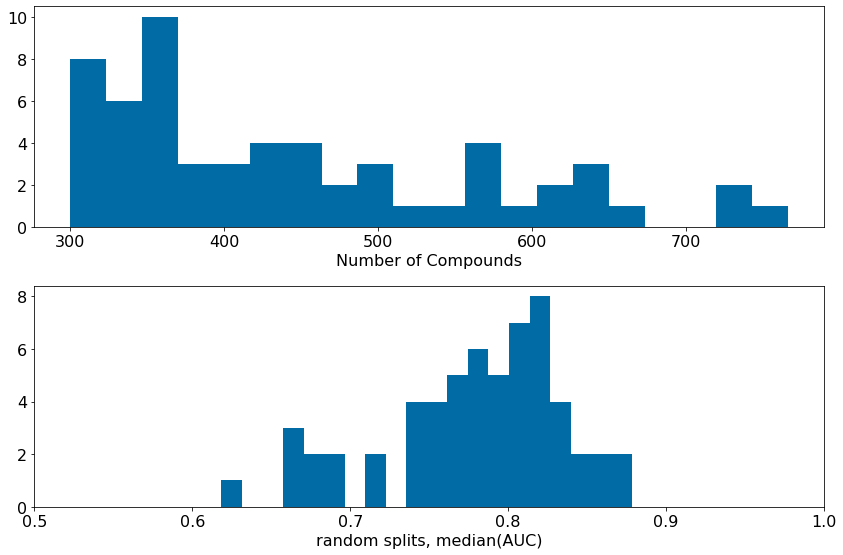

In [15]:
figsize(12,8)


subplot(2,1,1)
hist(sizes,
     bins=20, 
     );
xlabel('Number of Compounds')
subplot(2,1,2)
hist([
     [np.median(nogap_random_results_bal[x].rocs) for x in assays_80],
],
     bins=20, 
     );
xlim(0.5,1.0);
xlabel('random splits, median(AUC)');
plt.tight_layout()
plt.savefig(f'{figdir}/chembl_assays_summary.pdf',bbox_inches='tight')


7


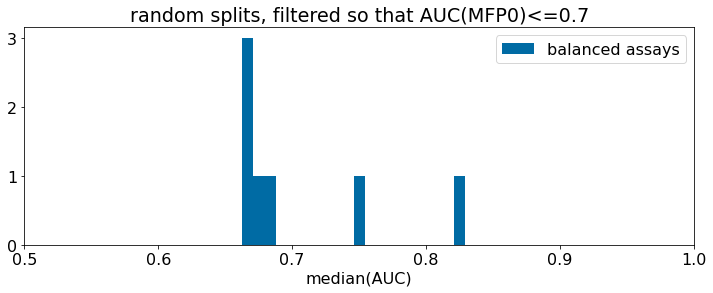

In [16]:
meds = np.array([np.median(mfp0_nogap_random_results_bal[x].rocs) for x in  mfp0_nogap_random_results_bal])
assays_70 = [x for x,m in zip(mfp0_nogap_random_results_bal,meds) if m<=0.70]
print(len(assays_70))
figsize(12,4)
hist([
     [np.median(nogap_random_results_bal[x].rocs) for x in assays_70],
],
     bins=20, 
     label=['balanced assays',]);
legend()
xlim(0.5,1.0);
xlabel('median(AUC)')
title('random splits, filtered so that AUC(MFP0)<=0.7');

Table with information about the 103 ChEMBL assays used as a starting point

In [17]:
catalog = intake.open_catalog('./datasets/public_data.yaml')
bioactivities = catalog.assays

sizes = []
for assay in bioactivities:
    ds = bioactivities[assay]
    metadata = ds.metadata
    if metadata['max pchembl_value']-metadata['min pchembl_value'] >= 3.0:
        sizes.append(len(ds.read()))
        print(rf'{assay} & {ds.metadata["activity_type"]} & {sizes[-1]} \\')
    
len(sizes)    
    

CHEMBL3888383 & IC50 & 794 \\
CHEMBL3705899 & IC50 & 766 \\
CHEMBL3706373 & Ki & 733 \\
CHEMBL3888158 & Ki & 724 \\
CHEMBL3705362 & IC50 & 720 \\
CHEMBL1267251 & IC50 & 653 \\
CHEMBL3887063 & IC50 & 643 \\
CHEMBL3706037 & IC50 & 641 \\
CHEMBL3888194 & IC50 & 641 \\
CHEMBL3706327 & IC50 & 630 \\
CHEMBL3880339 & IC50 & 620 \\
CHEMBL3888428 & IC50 & 620 \\
CHEMBL3880337 & IC50 & 618 \\
CHEMBL3880338 & IC50 & 617 \\
CHEMBL3888429 & IC50 & 607 \\
CHEMBL3880344 & IC50 & 601 \\
CHEMBL3705873 & IC50 & 600 \\
CHEMBL3880342 & IC50 & 597 \\
CHEMBL3705869 & IC50 & 596 \\
CHEMBL3880340 & IC50 & 587 \\
CHEMBL3705357 & IC50 & 584 \\
CHEMBL3706089 & IC50 & 574 \\
CHEMBL3706045 & Ki & 574 \\
CHEMBL1267246 & IC50 & 571 \\
CHEMBL1267249 & IC50 & 566 \\
CHEMBL3888190 & IC50 & 564 \\
CHEMBL3706329 & IC50 & 561 \\
CHEMBL3707623 & IC50 & 545 \\
CHEMBL1267245 & IC50 & 533 \\
CHEMBL3705647 & IC50 & 511 \\
CHEMBL3887033 & IC50 & 504 \\
CHEMBL3888966 & EC50 & 498 \\
CHEMBL1267250 & IC50 & 495 \\
CHEMBL3705960 & 

103

In [19]:
len(sizes)

103

## Look at some datasets with super-high scores

In [20]:
l = [np.median(nogap_random_results_bal[x].rocs) for x in assays]
ds = [(i,x) for i,x in enumerate(l) if x>0.95]
for i,x in ds:
    print(i,x,assays[i])

28 0.9822048611111112 CHEMBL3705869
79 0.9674812770989357 CHEMBL3888158
87 0.9669877819548872 CHEMBL3887333


In [21]:
from rdkit.Chem import rdFingerprintGenerator
import umap

def do_analysis(assay,isKi=False,tgt_frac=0.4,active_inactive_offset=0.0):
    numThreads = 4

    catalog = intake.open_catalog('./datasets/public_data.yaml')
    if isKi:
        bioactivities = catalog.bioactivities
    else:
        bioactivities = catalog.assays
    

    ds = bioactivities[assay]

    print('------------\nLoading data')
    df = ds.read()
    print(f'  original data size {len(df)}')
    # randomize the order of the molecules:
    # this is easy with a data frame, but you could also random.shuffle() a list if the mols are in a list.
    df = df.sample(frac=1, random_state=0xf00d)

    # generate the binned activity values
    pActs = np.array(
        [-1 * math.log10(x*1e-9) if x > 0 else 0 for x in df.standard_value])
    df['pActivity'] = pActs
    upper, lower = ga_lib.get_imbalanced_bins(pActs,tgt_frac=tgt_frac,active_inactive_offset=active_inactive_offset)
    print(f'  bins are: {lower:.2f} {upper:.2f}')
    df = df[(pActs >= upper) | (pActs <= lower)]
    binned = [1 if x >= upper else 0 for x in df.pActivity]
    df['active'] = ['active' if x == 1 else 'inactive' for x in binned]
    print(f'  post-binning data size {len(df)}')

    mols = [
        Chem.MolFromSmiles(tmp_smi)
        for tmp_smi in df['canonical_smiles'].to_numpy(dtype=str)
    ]

    generator = rdFingerprintGenerator.GetMorganGenerator(radius=2)
    fps = [generator.GetFingerprintAsNumPy(x) for x in mols]

#     print('------------\nRunning RF experiments')
#     rocs,scores,kappas,balanced = test_rf_model(fps,binned,numThreads=numThreads)
    
    print('------------\nDoing UMAP embedding')
    bfps = [generator.GetFingerprint(x) for x in mols]

    dmat = np.zeros((len(bfps),len(bfps)),float)
    for i,fp in enumerate(bfps):
        if i==len(bfps)-1:
            break
        ds = np.array(DataStructs.BulkTanimotoSimilarity(fp,bfps[i+1:],returnDistance=1))
        dmat[i,i+1:] = ds
        dmat[i+1:,i] = ds

    fit = umap.UMAP(
        n_neighbors=20,
        min_dist=0.4,
        n_components=2,
        metric='precomputed'
    )
    pts = fit.fit_transform(dmat)

    act_pts = [x for x,y in zip(pts,binned) if y]
    inact_pts = [x for x,y in zip(pts,binned) if not y]

    figsize(16,16)
    
    
    subplot(2,2,1)
    hist(df['pActivity'],bins=20);
    xlabel('pActivity')
    ylabel('count')
    
    miny,maxy = ylim()
    plot((lower,lower),(0,maxy),'k')
    plot((upper,upper),(0,maxy),'k')

    
    title(assay);
    
    subplot(2,2,3)
    x,y = zip(*act_pts)
    scatter(x,y)
    title('actives')

    minx,maxx = xlim()
    miny,maxy = ylim()

    subplot(2,2,4)
    x,y = zip(*inact_pts)
    scatter(x,y,color='r')
    title('inactives')
    xlim(minx,maxx)
    ylim(miny,maxy);    
    

In [22]:
figdir

'/home/glandrum/Papers/MolecularTimeSeries/images/'

------------
Loading data
  original data size 596
  bins are: 6.80 6.80
  post-binning data size 596
------------
Doing UMAP embedding


/localhome/glandrum/.conda/envs/pymoo/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


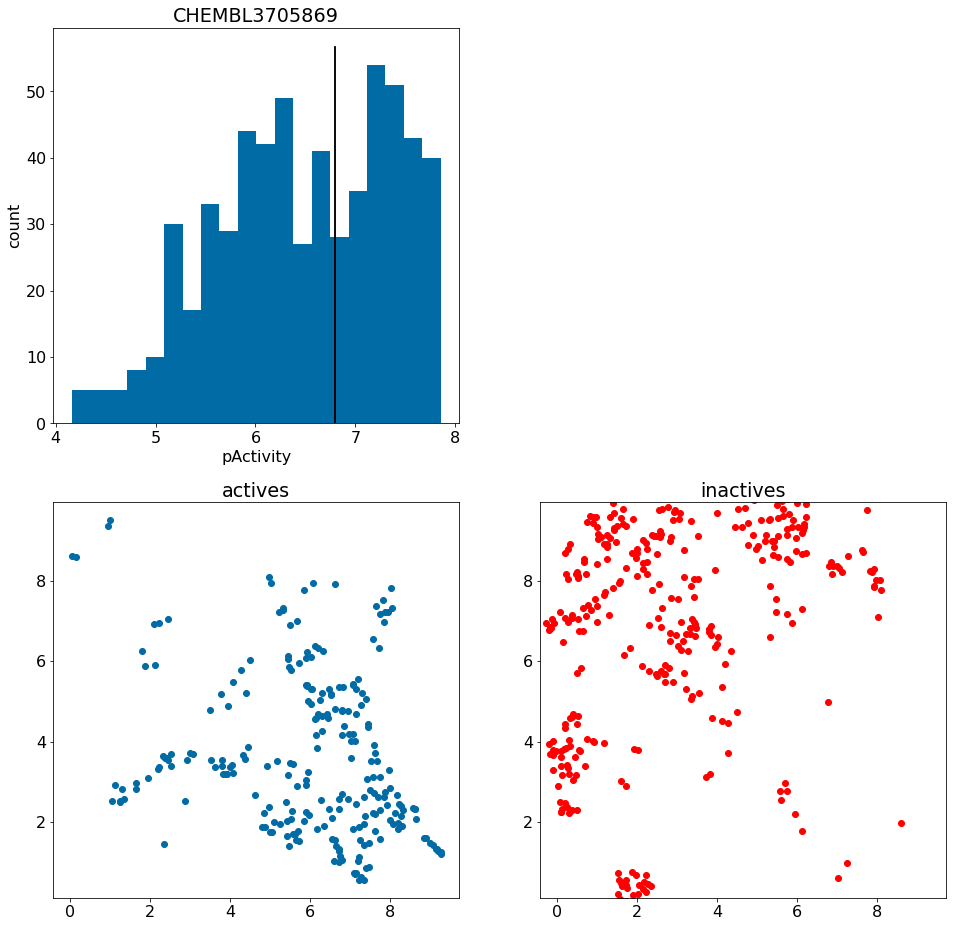

In [23]:
do_analysis('CHEMBL3705869')
plt.savefig(f'{figdir}/chembl_assays_umap_for_high_accuracy_assay.pdf',bbox_inches='tight')


------------
Loading data
  original data size 724
  bins are: 7.90 7.90
  post-binning data size 724
------------
Doing UMAP embedding


/localhome/glandrum/.conda/envs/pymoo/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


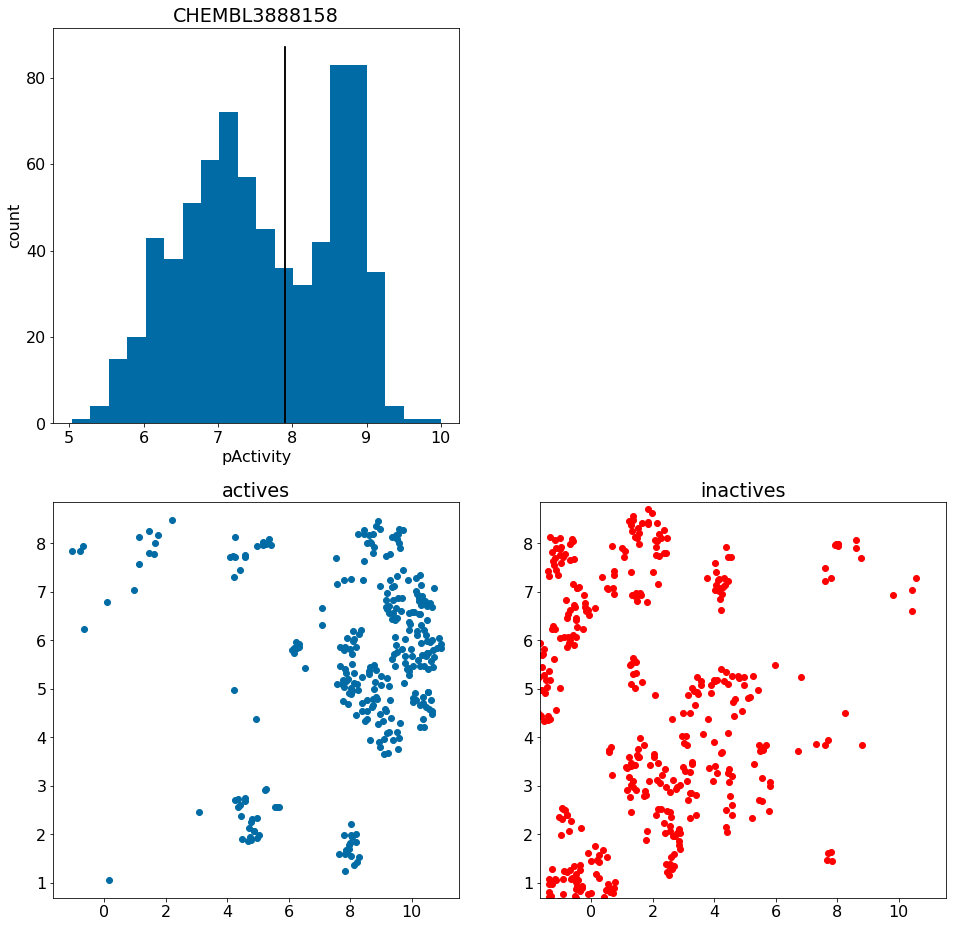

In [24]:
do_analysis('CHEMBL3888158')

------------
Loading data
  original data size 468
  bins are: 6.90 6.90
  post-binning data size 468
------------
Doing UMAP embedding


/localhome/glandrum/.conda/envs/pymoo/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


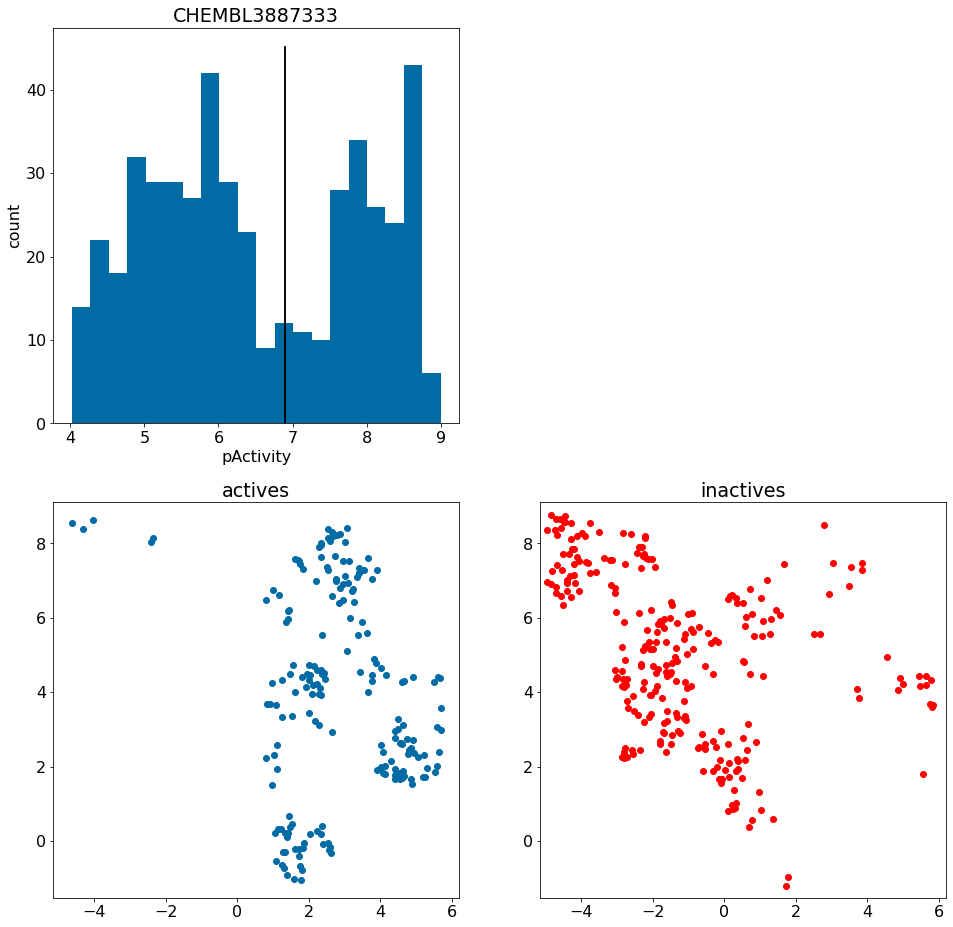

In [25]:
do_analysis('CHEMBL3887333')

# Look at GA results

In [11]:
restuple = namedtuple('restuple',['rocs','scores','kappas','BAs'])

fns = glob.glob('./nogap_alt_moo_ml_results_balanced_assay/*.favorfg_rf.pkl.gz')
results_moo_fg_bal = {}
for fn in fns:
    assay = os.path.basename(fn).split('_')[0]
    if assay not in assays_80:
        continue
    with gzip.open(fn,'rb') as inf:
        tpl = restuple(*pickle.load(inf))
    results_moo_fg_bal[assay] = tpl
moo_assays = list(results_moo_fg_bal.keys())
    

In [12]:
len(assays),len(set(assays).intersection(moo_assays)),len(moo_assays)

(103, 56, 56)

In [15]:
catalog = intake.open_catalog('./datasets/public_data.yaml')
bioactivities = catalog.assays


print('Assay, Activity type, Number of Compounds')
sizes = []
for assay in moo_assays:
    ds = bioactivities[assay]
    sizes.append(len(ds.read()))
    print(rf'{assay}, {ds.metadata["activity_type"]}, {sizes[-1]}')
len(sizes)

Assay, Activity type, Number of Compounds
CHEMBL3705542, Ki, 363
CHEMBL1267245, IC50, 533
CHEMBL3705282, IC50, 317
CHEMBL3705464, IC50, 306
CHEMBL3705362, IC50, 720
CHEMBL1267248, IC50, 339
CHEMBL1267250, IC50, 495
CHEMBL1267247, IC50, 425
CHEMBL3888268, Ki, 347
CHEMBL3734252, IC50, 357
CHEMBL3707962, IC50, 317
CHEMBL3706310, IC50, 367
CHEMBL3880337, IC50, 618
CHEMBL3880338, IC50, 617
CHEMBL3721139, EC50, 310
CHEMBL3734552, EC50, 395
CHEMBL3707951, IC50, 318
CHEMBL3705813, IC50, 357
CHEMBL3705899, IC50, 766
CHEMBL3706373, Ki, 733
CHEMBL3705655, IC50, 430
CHEMBL3887759, IC50, 333
CHEMBL3706316, IC50, 365
CHEMBL3705791, IC50, 313
CHEMBL3706089, IC50, 574
CHEMBL3887796, IC50, 458
CHEMBL3705971, Ki, 427
CHEMBL3705924, IC50, 325
CHEMBL3887188, IC50, 324
CHEMBL3705647, IC50, 511
CHEMBL3887296, IC50, 398
CHEMBL3887679, IC50, 376
CHEMBL3887849, IC50, 446
CHEMBL3887758, IC50, 440
CHEMBL3706037, IC50, 641
CHEMBL3888087, EC50, 382
CHEMBL3887887, IC50, 464
CHEMBL3887757, IC50, 457
CHEMBL3880340, I

56

In [29]:
print(moo_assays)

['CHEMBL1267247', 'CHEMBL3705464', 'CHEMBL3705282', 'CHEMBL1267250', 'CHEMBL3705791', 'CHEMBL3705655', 'CHEMBL3705542', 'CHEMBL3705813', 'CHEMBL3705362', 'CHEMBL3705790', 'CHEMBL1267248', 'CHEMBL3705647', 'CHEMBL3705924', 'CHEMBL3705899', 'CHEMBL3706310', 'CHEMBL3705960', 'CHEMBL1267245', 'CHEMBL3705971', 'CHEMBL3706037', 'CHEMBL3880337', 'CHEMBL3706089', 'CHEMBL3706316', 'CHEMBL3887061', 'CHEMBL3734252', 'CHEMBL3887063', 'CHEMBL3887188', 'CHEMBL3880340', 'CHEMBL3880338', 'CHEMBL3887296', 'CHEMBL3887679', 'CHEMBL3887033', 'CHEMBL3734552', 'CHEMBL3707951', 'CHEMBL3707962', 'CHEMBL3888268', 'CHEMBL3721139', 'CHEMBL3887987', 'CHEMBL3706373', 'CHEMBL3887758', 'CHEMBL3888087', 'CHEMBL3887945', 'CHEMBL3887759', 'CHEMBL3888190', 'CHEMBL3887757', 'CHEMBL3888194', 'CHEMBL3887796', 'CHEMBL3887849', 'CHEMBL3888295', 'CHEMBL3887887', 'CHEMBL3888977', 'CHEMBL3889139', 'CHEMBL3888980', 'CHEMBL3889082', 'CHEMBL3889083', 'CHEMBL3888825', 'CHEMBL3888966']


In [30]:
random_meds = [np.median(nogap_random_results_bal[x].rocs) for x in moo_assays]
moo_meds = [np.median(results_moo_bal[x].rocs) for x in moo_assays]
moo_fg_first = [results_moo_fg_bal[x].rocs[0] for x in moo_assays]

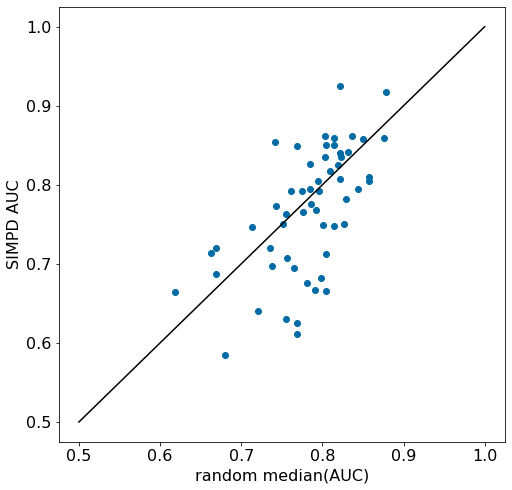

In [32]:
figsize(8,8)
scatter(random_meds,moo_fg_first,label='favor F&G');
plot((.5,1),(.5,1),'k');
xlabel('random median(AUC)')
ylabel('SIMPD AUC')
plt.savefig(f'{figdir}/chembl_assays_ga_impact_on_model_performance.pdf',bbox_inches='tight')


# Look at GA objectives

In [34]:
len(moo_assays)

56

In [35]:
catalog = intake.open_catalog('./datasets/public_data.yaml')
bioactivities = catalog.assays

alt_alltgts = defaultdict(list)
alt_alldesc = defaultdict(list)
random_fgvals = defaultdict(list)
for assay in moo_assays:
    ares = alt_compliance_analysis(assay)
    if 0 not in ares or 1 not in ares:
        print(f'skipping {assay}')
        continue
    random_fgvals[-1].append(ares[-1])
    
    for scen in (0,1):
        alt_alltgts[scen].append(ares[scen][0])
        alt_alldesc[scen].append(ares[scen][1])

------------
Loading data
  bins are: 5.10 5.10
  post-binning data size 425
425
working with 425 points and picking 85
------------
Loading data
  bins are: 9.60 9.60
  post-binning data size 306
306
working with 306 points and picking 61
------------
Loading data
  bins are: 7.10 7.10
  post-binning data size 317
317
working with 317 points and picking 63
------------
Loading data
  bins are: 5.20 5.20
  post-binning data size 495
495
working with 495 points and picking 99
------------
Loading data
  bins are: 6.70 6.70
  post-binning data size 313
313
working with 313 points and picking 62
------------
Loading data
  bins are: 7.30 7.30
  post-binning data size 430
430
working with 430 points and picking 86
------------
Loading data
  bins are: 10.00 10.00
  post-binning data size 363
363
working with 363 points and picking 72
------------
Loading data
  bins are: 8.20 8.20
  post-binning data size 357
357
working with 357 points and picking 71
------------
Loading data
  bins are: 

In [44]:
import pickle
with open('./chembl_alt_moo_objectives_selected_assays.pkl','wb+') as outf:
    pickle.dump((alt_alltgts,alt_alldesc),outf)

In [36]:
import pickle
with open('./chembl_alt_moo_objectives_selected_assays.pkl','rb') as inf:
    (alt_alltgts,alt_alldesc) = pickle.load(inf)

In [37]:
len(alt_alltgts[1]),len(moo_assays)

(56, 56)

In [38]:
catalog = intake.open_catalog('./datasets/public_data.yaml')
bioactivities = catalog.assays

diffs = set(assays_80).difference(moo_assays)
for d in diffs:
    print(bioactivities[d].description)

Assay CHEMBL1267251: Antiplasmodial activity against Plasmodium falciparum W2 after 72 hrs by SYBR green assay
Assay CHEMBL1267249: Antiplasmodial activity against Plasmodium falciparum GB4 after 72 hrs by SYBR green assay
Assay CHEMBL1267246: Antiplasmodial activity against Plasmodium falciparum 7G8 after 72 hrs by SYBR green assay


In [39]:
len([1 for x in assays_80 if 'Antiplasmodial' in bioactivities[x].description])

7

## reweighting

In [40]:
catalog = intake.open_catalog('./datasets/public_data.yaml')
bioactivities = catalog.assays

strategy='CLUSTERS_SPLIT'
popSize=500
nGens=300
ares0 = defaultdict(list)
best_F0 = defaultdict(list)
ares1 = defaultdict(list)
best_F1 = defaultdict(list)
ares2 = defaultdict(list)
best_F2 = defaultdict(list)
idx = [0]
for assay in moo_assays:
    for scen in range(len(idx)):
        fname = f'./nogap_alt_results_balanced_assay/{assay}_{strategy}.{popSize}.{nGens}.altscenario_{scen}.pkl.gz'
        if not os.path.exists(fname):
            continue
        with gzip.open(fname,'rb') as inf:
            train_inds,test_inds = pickle.load(inf)
            Fs,Gs,Xs = pickle.load(inf)
        scores1 = score_pareto_solutions(Fs,weights=[1.]*7)
        scores2 = score_pareto_solutions(Fs,weights=[1.]*5+[10.,5.])
        best1 = np.argmax(scores1)
        best2 = np.argmax(scores2)
        
        best_F0[scen].append(Fs[0])
        best_F1[scen].append(Fs[best1])
        best_F2[scen].append(Fs[best2])
        
        ares0[scen].append(alt_alldesc[scen][idx[scen]][0])
        ares1[scen].append(alt_alldesc[scen][idx[scen]][best1])
        ares2[scen].append(alt_alldesc[scen][idx[scen]][best2])
        idx[scen] += 1

for k in ares1:
    for d in (ares0,ares1,ares2,best_F0,best_F1,best_F2):
        d[k] = np.array(d[k])
        

        

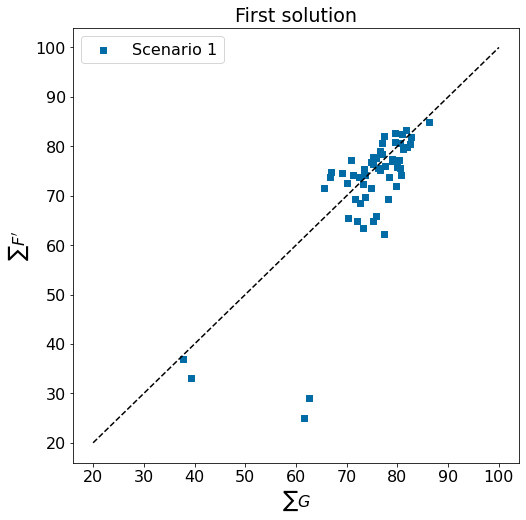

In [41]:
       
figsize(8,8)
scatter(ares0[0][:,6],ares0[0][:,5],marker='s',color='C0',label='Scenario 1');

plot((20,100),(20,100),'k--')

    
    
xlabel('$\sum G$');
ylabel('$\sum F\'$');
title('First solution');
legend();

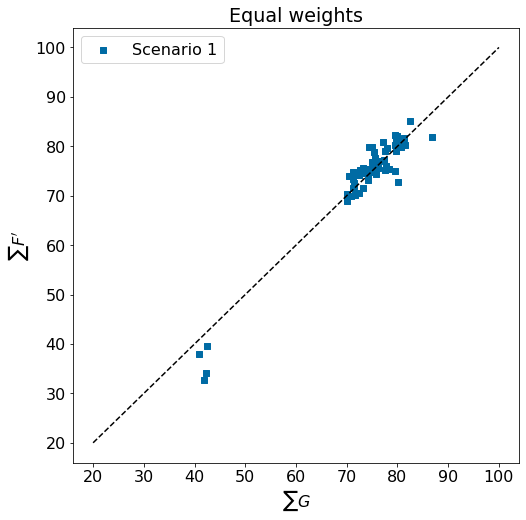

In [42]:
       
figsize(8,8)
scatter(ares1[0][:,6],ares1[0][:,5],marker='s',color='C0',label='Scenario 1');

plot((20,100),(20,100),'k--')

    
    
xlabel('$\sum G$');
ylabel('$\sum F\'$');
title('Equal weights');
legend();

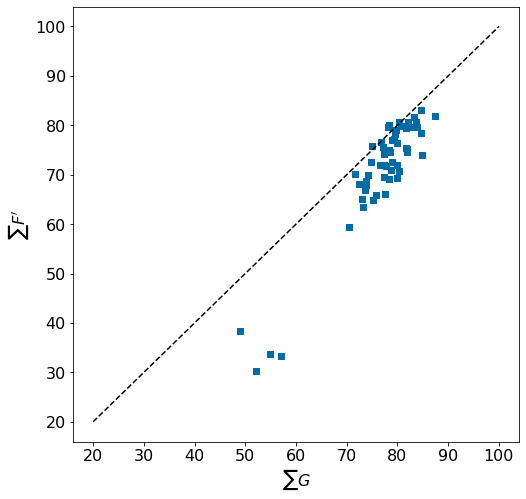

In [43]:
       
figsize(8,8)
scatter(ares2[0][:,6],ares2[0][:,5],marker='s',color='C0',label='Scenario 1');
plot((20,100),(20,100),'k--') 
    
xlabel('$\sum G$');
ylabel('$\sum F\'$');
plt.savefig(f'{figdir}/chembl_assays_spatial_stats.pdf',bbox_inches='tight')


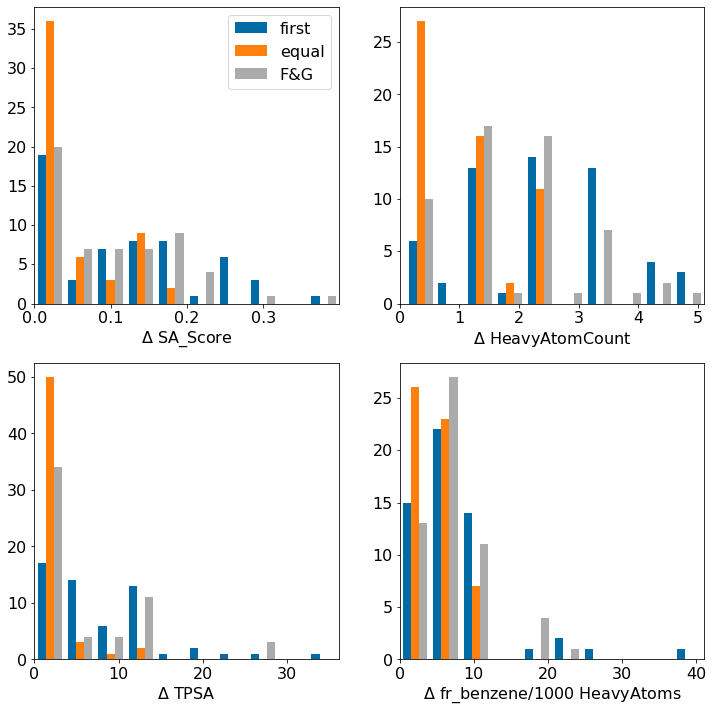

In [44]:
descrs = [x.descriptor for x in ga_lib.descrs]
figsize(12,12)
for i in range(4):
    subplot(2,2,i+1)
    hist([best_F0[0][:,i],best_F1[0][:,i],best_F2[0][:,i]],label=('first','equal','F&G'))
    mx = max(max(best_F0[0][:,i]),
             max(best_F1[0][:,i]),
             max(best_F2[0][:,i]),
            )
    xlim(0,mx)
    xlabel(f'$\Delta$ {descrs[i]}');
    if not i:
        legend();
plt.savefig(f'{figdir}/chembl_assays_descriptor_match_comparison.pdf',bbox_inches='tight')
    

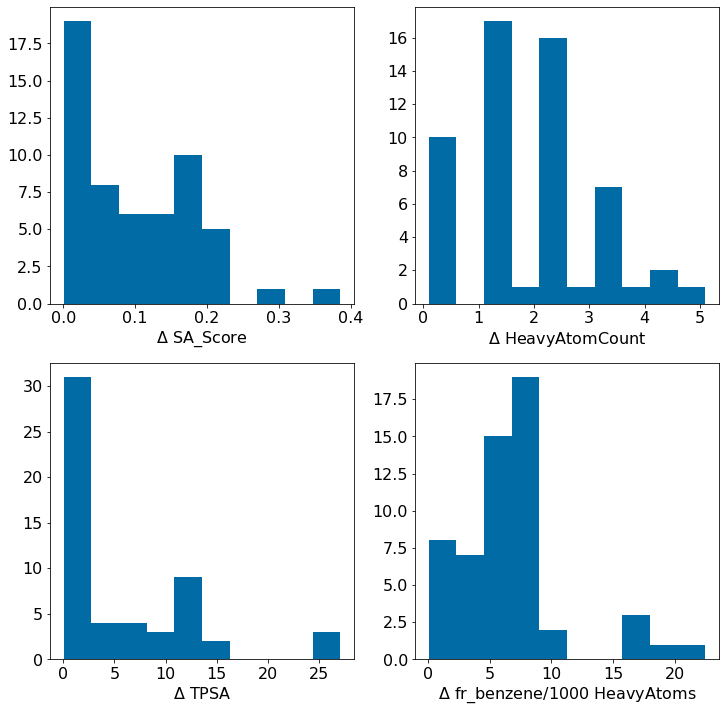

In [45]:
descrs = [x.descriptor for x in ga_lib.descrs]
figsize(12,12)
for i in range(4):
    subplot(2,2,i+1)
    hist([best_F2[0][:,i]],label=('F&G',))
    xlabel(f'$\Delta$ {descrs[i]}');
        
plt.savefig(f'{figdir}/chembl_assays_descriptor_match.pdf',bbox_inches='tight')


### Investigation of the very low scoring assays

In [46]:
low_scorers = [(i,v,ares2[0][i,6]) for i,v in enumerate(moo_assays) if ares2[0][i,6]<60]
low_scorers

[(0, 'CHEMBL1267247', 49.035294117647055),
 (3, 'CHEMBL1267250', 52.141414141414145),
 (10, 'CHEMBL1267248', 54.895522388059696),
 (16, 'CHEMBL1267245', 57.00943396226415)]

In [47]:
for i,v,s in low_scorers:
    print(bioactivities[v].description)

Assay CHEMBL1267247: Antiplasmodial activity against Plasmodium falciparum D10 after 72 hrs by SYBR green assay
Assay CHEMBL1267250: Antiplasmodial activity against Plasmodium falciparum HB3 after 72 hrs by SYBR green assay
Assay CHEMBL1267248: Antiplasmodial activity against Plasmodium falciparum Dd2 after 72 hrs by SYBR green assay
Assay CHEMBL1267245: Antiplasmodial activity against Plasmodium falciparum 3D7 after 72 hrs by SYBR green assay


Assay CHEMBL1267247: Antiplasmodial activity against Plasmodium falciparum D10 after 72 hrs by SYBR green assay
------------
Loading data
  original data size 425
  bins are: 5.10 5.10
  post-binning data size 425
------------
Doing UMAP embedding


/localhome/glandrum/.conda/envs/pymoo/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


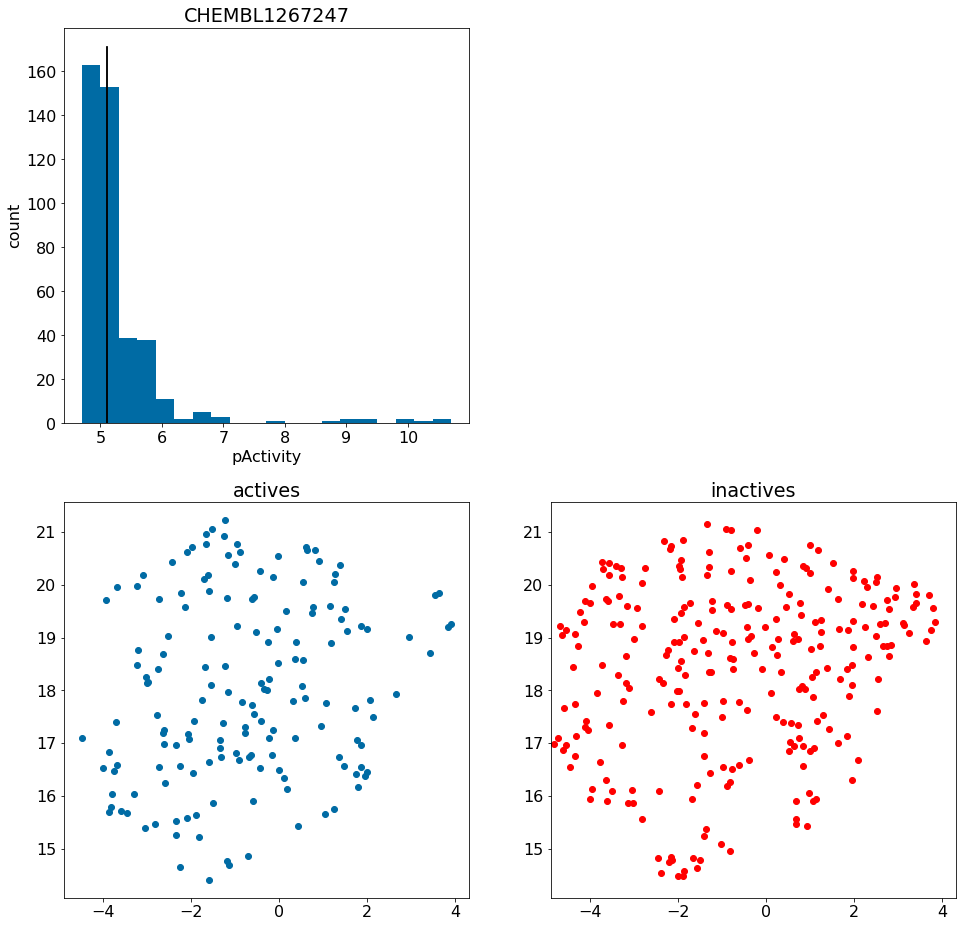

In [48]:
print(bioactivities['CHEMBL1267247'].description)
do_analysis('CHEMBL1267247')


Assay CHEMBL1267250: Antiplasmodial activity against Plasmodium falciparum HB3 after 72 hrs by SYBR green assay
------------
Loading data
  original data size 495
  bins are: 5.20 5.20
  post-binning data size 495
------------
Doing UMAP embedding


/localhome/glandrum/.conda/envs/pymoo/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


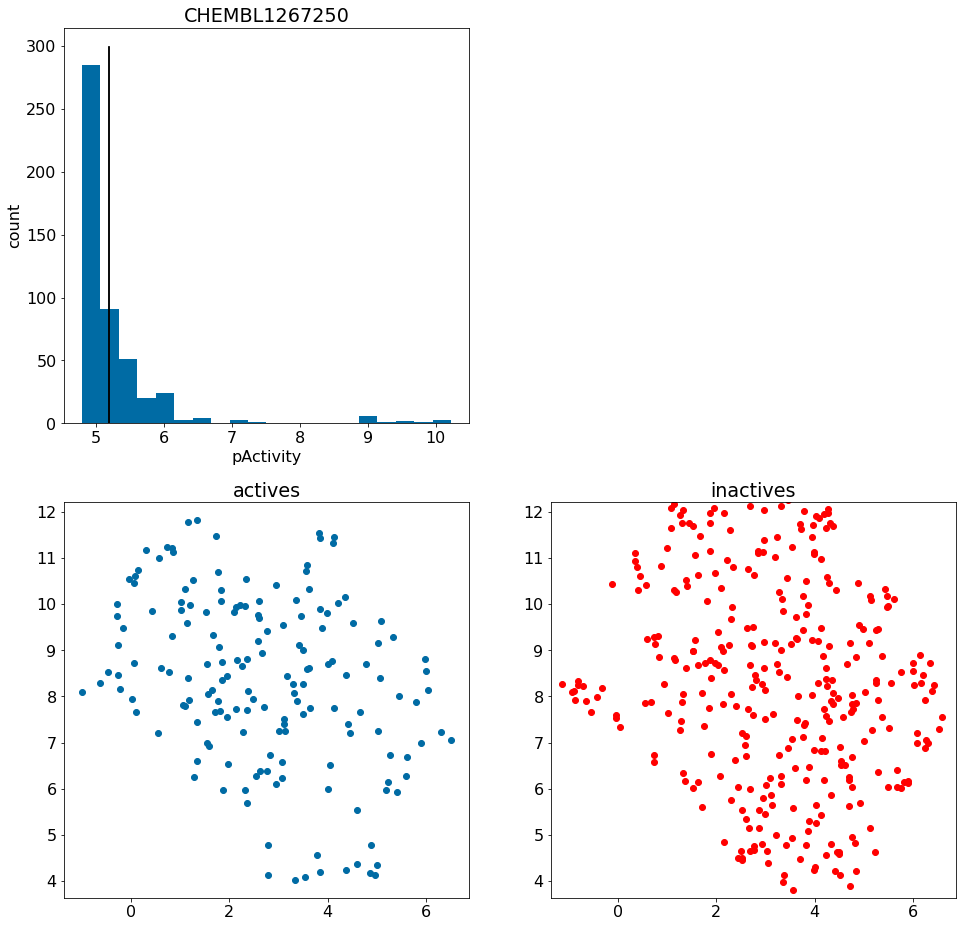

In [49]:
print(bioactivities['CHEMBL1267250'].description)
do_analysis('CHEMBL1267250')


Assay CHEMBL1267248: Antiplasmodial activity against Plasmodium falciparum Dd2 after 72 hrs by SYBR green assay
------------
Loading data
  original data size 339
  bins are: 5.20 5.20
  post-binning data size 339
------------
Doing UMAP embedding


/localhome/glandrum/.conda/envs/pymoo/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


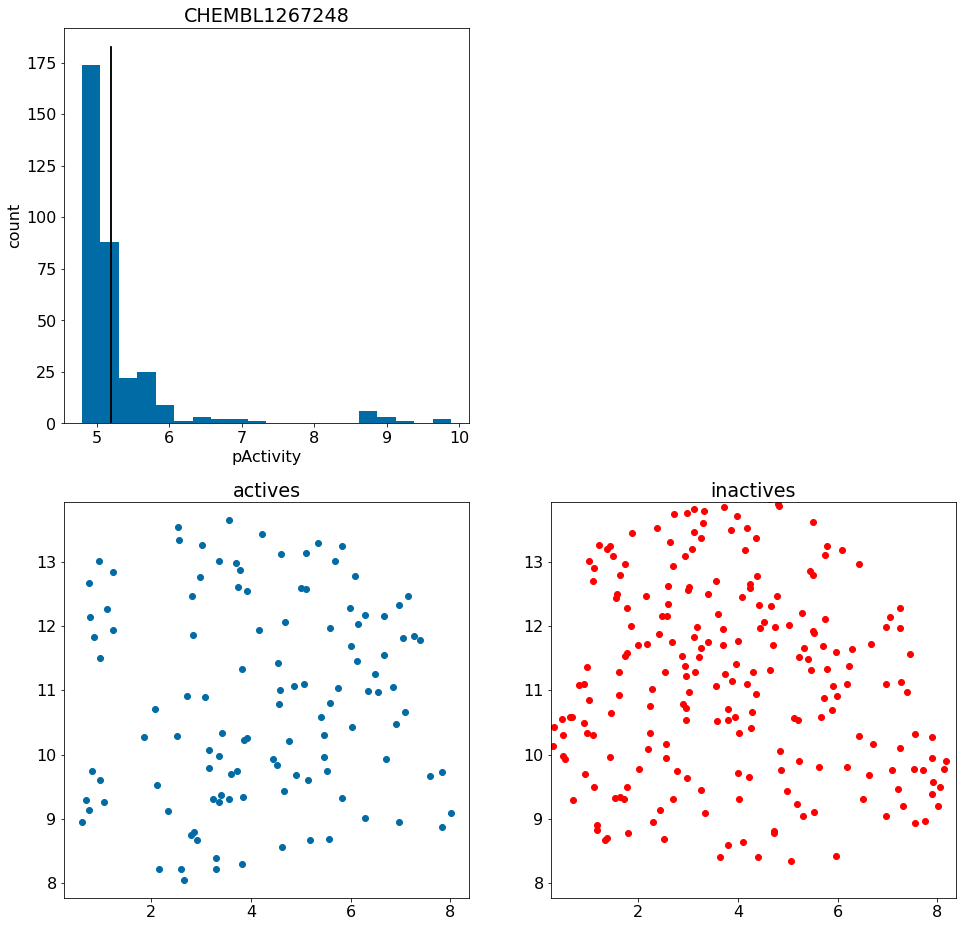

In [50]:
print(bioactivities['CHEMBL1267248'].description)
do_analysis('CHEMBL1267248')


Assay CHEMBL1267245: Antiplasmodial activity against Plasmodium falciparum 3D7 after 72 hrs by SYBR green assay
------------
Loading data
  original data size 533
  bins are: 5.10 5.10
  post-binning data size 533
------------
Doing UMAP embedding


/localhome/glandrum/.conda/envs/pymoo/lib/python3.9/site-packages/umap/umap_.py:1780: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")


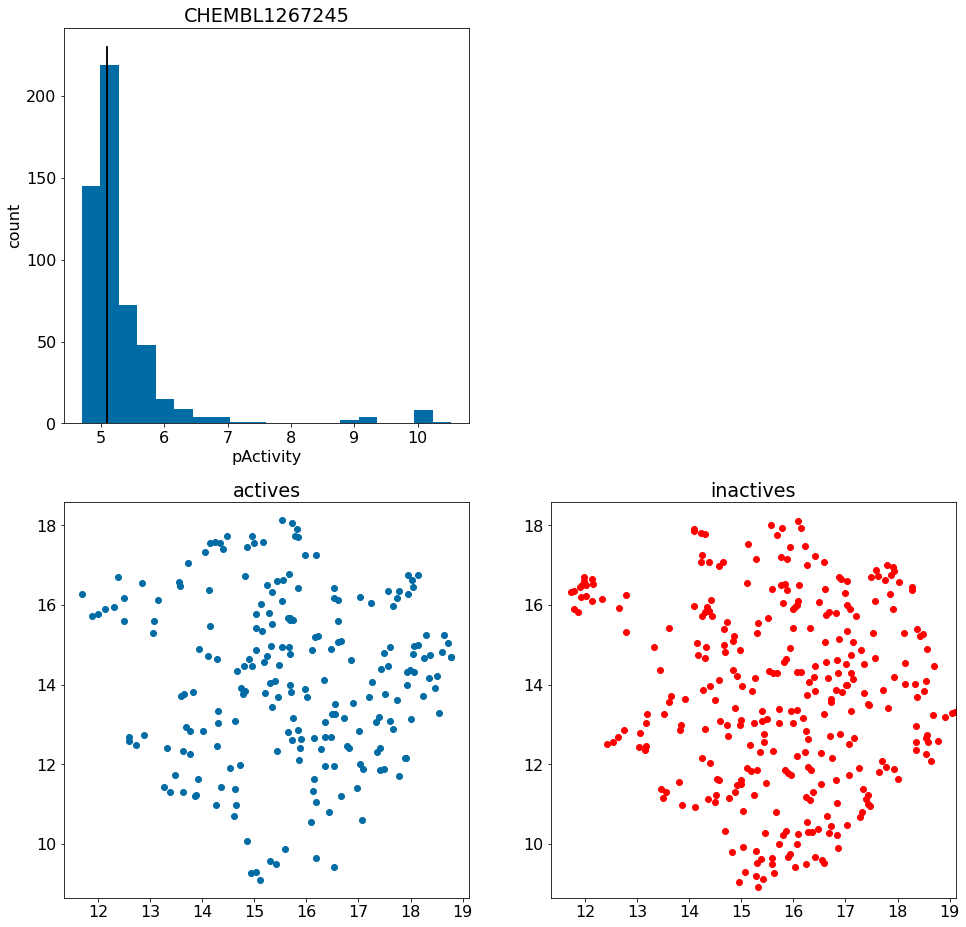

In [51]:
print(bioactivities['CHEMBL1267245'].description)
do_analysis('CHEMBL1267245')


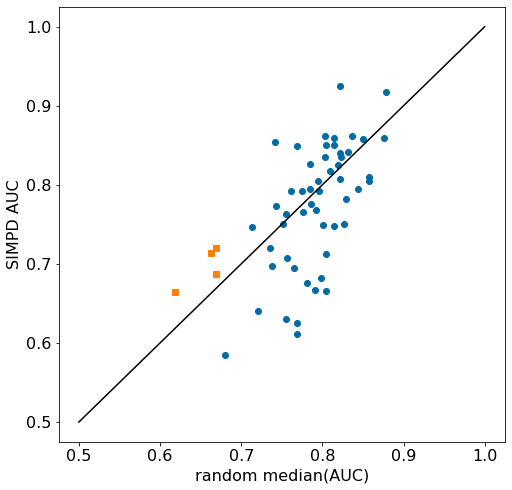

In [52]:
low_indices = [i for i,v,s in low_scorers]
figsize(8,8)
scatter(random_meds,moo_fg_first,label='other');
scatter(np.take(random_meds,low_indices),
        np.take(moo_fg_first,low_indices),label='screening assays',
       marker='s');
plot((.5,1),(.5,1),'k');
xlabel('random median(AUC)')
ylabel('SIMPD AUC');
plt.savefig(f'{figdir}/chembl_assays_ga_impact_on_model_performance.pdf',bbox_inches='tight')


# Look at variability among the GA solutions

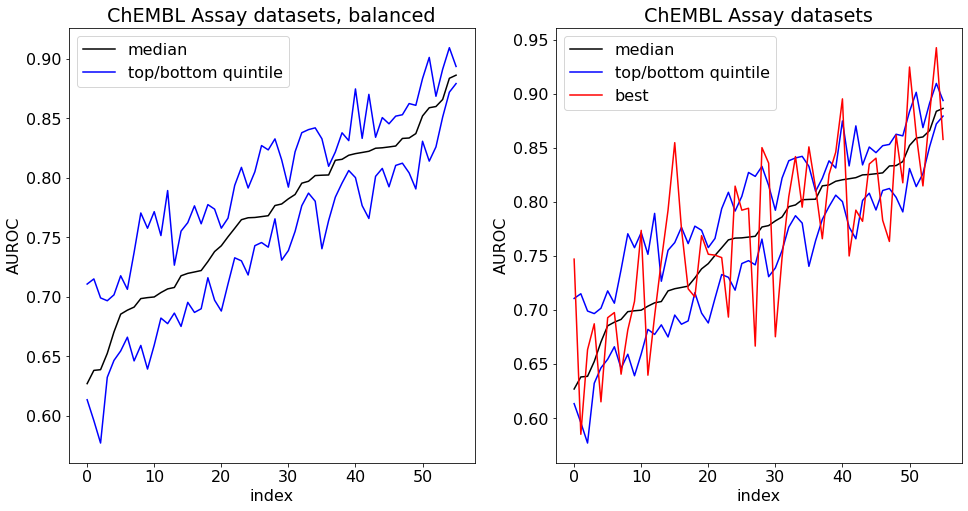

In [136]:
figsize(16,8)
assays_bal_moo_fg_meds = [np.median(results_moo_fg_bal[x].rocs) for x in moo_assays]
assays_bal_moo_fg_mins = [np.min(results_moo_fg_bal[x].rocs) for x in moo_assays]
assays_bal_moo_fg_maxs = [np.max(results_moo_fg_bal[x].rocs) for x in moo_assays]

bins = [np.quantile(results_moo_fg_bal[x].rocs,[.2,.8]) for x in moo_assays]

order = np.argsort(assays_bal_moo_fg_meds)
mins,maxs = zip(*bins)
firsts = [results_moo_bal[x].rocs[0] for x in moo_assays]

subplot(1,2,1)
plot(np.take(assays_bal_moo_fg_meds,order),'k',label='median')
plot(np.take(mins,order),'b',label='top/bottom quintile')
plot(np.take(maxs,order),'b')
legend()

ylabel('AUROC')
xlabel('index')
title('ChEMBL Assay datasets, balanced');

subplot(1,2,2)
plot(np.take(assays_bal_moo_fg_meds,order),'k',label='median')
plot(np.take(mins,order),'b',label='top/bottom quintile')
plot(np.take(maxs,order),'b')
plot(np.take(firsts,order),'r',label='best')
legend()
ylabel('AUROC')
xlabel('index')
title('ChEMBL Assay datasets');


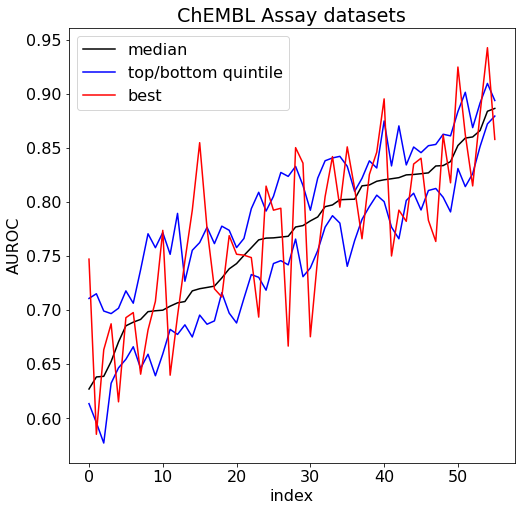

In [137]:
figsize(8,8)
assays_bal_moo_fg_meds = [np.median(results_moo_fg_bal[x].rocs) for x in moo_assays]
assays_bal_moo_fg_mins = [np.min(results_moo_fg_bal[x].rocs) for x in moo_assays]
assays_bal_moo_fg_maxs = [np.max(results_moo_fg_bal[x].rocs) for x in moo_assays]

bins = [np.quantile(results_moo_fg_bal[x].rocs,[.2,.8]) for x in moo_assays]

order = np.argsort(assays_bal_moo_fg_meds)
mins,maxs = zip(*bins)
firsts = [results_moo_bal[x].rocs[0] for x in moo_assays]

plot(np.take(assays_bal_moo_fg_meds,order),'k',label='median')
plot(np.take(mins,order),'b',label='top/bottom quintile')
plot(np.take(maxs,order),'b')
plot(np.take(firsts,order),'r',label='best')
legend()
ylabel('AUROC')
xlabel('index')
title('ChEMBL Assay datasets');
plt.savefig(f'{figdir}/chembl_assays_auroc_variability.pdf',bbox_inches='tight')
